### Get all imports

In [1]:
import os
import random
import numpy as np
import torch
import numpy as np
from torchvision import datasets, transforms
import math
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [2]:
def set_seed(seed=27):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

# create a device variable which will be used to shift model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(seed=27)

Random seed set as 27


### Download the data and create a pytorch dataset with necessary augmentations 

In [3]:
train_set = datasets.FashionMNIST(root='data/', train=True, transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.286), (0.3202)),
    transforms.Lambda(torch.flatten)
]), download=True)
# Load the validation set
val_set = datasets.FashionMNIST(root='data/', train=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.286), (0.3202)),
    transforms.Lambda(torch.flatten)
]))

batch_size = 512
dataloader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)

### Create a Feed Forward Neural Network a.k.a Multi-Layer Perceptron (MLP)

In [4]:
class FFN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define the layers
        self.layers = torch.nn.Sequential(*[torch.nn.Linear(784, 512),
                                           torch.nn.Linear(512, 256),
                                           torch.nn.Linear(256, 64),
                                           torch.nn.Linear(64, 10)])
        # Define the corresponding masks
        self.masks = torch.nn.ParameterList([torch.nn.Parameter(torch.Tensor(torch.ones(512, 784)), requires_grad=False),
                                             torch.nn.Parameter(torch.Tensor(torch.ones(256, 512)), requires_grad=False),
                                             torch.nn.Parameter(torch.Tensor(torch.ones(64, 256)), requires_grad=False),
                                             torch.nn.Parameter(torch.Tensor(torch.ones(10, 64)), requires_grad=False)
                                            ])
    
    def forward(self, x):
        # First multiply each layer's weights with its corresponding mask
        with torch.no_grad():
            for i in range(len(self.layers)):
                self.layers[i].weight.copy_(self.layers[i].weight.data * self.masks[i])
        # Now perform forward pass
        for i in range(len(self.layers)):
            if i < len(self.layers)-1:
                x = torch.nn.ReLU()(self.layers[i](x))
            else:
                return self.layers[i](x)
        return x

### Model training routine for each round

In [5]:
def train_model(epochs, dataloader, device, model, optimizer, loss_function):
    # Set model to the training mode in order to unfreeze all layers and allow gradient propagation
    model.train()
    # These two lists will be used to store average loss and accuracy for each epoch
    total_loss, acc = list(), list()
    # Now write out the training procedure
    for epoch in range(epochs):
        print("Epoch:", epoch+1)
        # Each batch produces a loss, predictions and target
        batch_loss, batch_preds, batch_target = 0, list(), list()
        # For each batch, train the model
        for x, y in tqdm(dataloader, total=len(dataloader)):
            # Make sure that data is on the same device as the model
            x, y = x.to(device), y.to(device)
            # Remove all previous gradients
            optimizer.zero_grad()
            # Get predictions by performing a forward pass
            preds = model.forward(x.float())
            # Calculate error
            loss = loss_function(preds, y.to(torch.int64))
            # Calculate all the gradients for each layer
            loss.backward()
            # Finall, update the weights
            optimizer.step()
            # Save the loss
            batch_loss+= loss.item()
            # Save the predictions and target
            batch_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))
            batch_target.extend(y.cpu().detach().numpy())
        # Calculate average loss
        total_loss.append(batch_loss/len(dataloader))
        # Calculate accuracy for this epoch
        acc.append(accuracy_score(batch_target, batch_preds))
        print("Loss:", total_loss[-1], "\tAcc:", acc[-1])
    return model, total_loss, acc

def test_model(dataloader, device, model):
    # Set model to eval mode in order to freeze all layers so that no parameter gets updated during testing
    model.eval()
    # Each batch produces a loss, predictions and target
    batch_preds, batch_target = list(), list()
    # For each batch, train the model
    for x, y in tqdm(dataloader, total=len(dataloader)):
        # Make sure that data is on the same device as the model
        x, y = x.to(device), y.to(device)
        preds = model.forward(x.float())
        # Save the predictions and target
        batch_preds.extend(np.argmax(preds.cpu().detach().numpy(), axis=1))
        batch_target.extend(y.cpu().detach().numpy())
    return accuracy_score(batch_target, batch_preds)

### Now perform model training

In [6]:
# Set the number of epochs to be used
epochs = 5
# Set the number of rounds
rounds = 5
# Set the sparsity level for each layer
sparsity = 0.1
# Create the model
model = FFN().to(device)
# Define Loss
loss_function = torch.nn.CrossEntropyLoss()
# Define Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# First save the model weights that have been initialized
init_weights = [model.layers[i].weight.data.to(device) for i in range(len(model.layers))]

for round_ in range(rounds):
    print("\n\n\nROUND", round_+1, "Started\n----------------------")
    # First train the model for some epochs
    model, _, _ = train_model(epochs, dataloader_train, device, model, optimizer, loss_function)
    if round_ == 0:
        print("Test Accuracy before pruning:", test_model(dataloader_val, device, model))
    else:
        print("Test Accuracy after pruning and retraining:", test_model(dataloader_val, device, model))
    with torch.no_grad():
        # Now prune the model weights
        for i in range(len(model.layers)):
            # print(model.layers[i].weight.data.shape)
            num_rows = model.layers[i].weight.data.shape[0]
            num_cols = model.layers[i].weight.data.shape[1]
            # Random pruning
#             indices = np.random.randint(0, num_rows*num_cols, num_rows*num_cols)
            # Lottery Ticket Style Pruning
            indices = torch.argsort(torch.reshape(torch.abs(model.layers[i].weight.data), (1, num_rows*num_cols)).squeeze())
            # Since we already have the indices to prune, first reset the parameters
            model.layers[i].weight.copy_(init_weights[i])
            # Now prune
            model.masks[i] = torch.reshape(model.masks[i], (1, num_rows*num_cols)).squeeze()
            val = ((sparsity*100)**((round_+1)/rounds))/100
            model.masks[i][indices[:math.ceil(val*num_rows*num_cols)]] = 0
            model.masks[i] = torch.reshape(torch.reshape(model.masks[i], (1, num_rows*num_cols)).squeeze(), (num_rows, num_cols))
    print("Test Accuracy after pruning but no retraining:", test_model(dataloader_val, device, model))




ROUND 1 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.5849229653002852 	Acc: 0.7824166666666666
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.3744929000987845 	Acc: 0.8630833333333333
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.3394818843926414 	Acc: 0.87505
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.318255076090158 	Acc: 0.8822
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.30109154786598885 	Acc: 0.88715


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy before pruning: 0.8613


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8614



ROUND 2 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.2881379944540687 	Acc: 0.89175
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.275548414911254 	Acc: 0.8960333333333333
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.26208930235292954 	Acc: 0.90085
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.25093760189868636 	Acc: 0.9055166666666666
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.24178819370976948 	Acc: 0.9075333333333333


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8842


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8842



ROUND 3 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.23880799645084447 	Acc: 0.9103166666666667
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.22637698370016227 	Acc: 0.91375
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.21475059766385515 	Acc: 0.91865
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.21472841791682323 	Acc: 0.9182666666666667
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.20547987672231965 	Acc: 0.9219833333333334


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8884


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8882



ROUND 4 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1974581755318884 	Acc: 0.9246666666666666
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.19147798772585595 	Acc: 0.9276
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.18614544252217827 	Acc: 0.92965
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.18393493342702671 	Acc: 0.9303666666666667
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.18539869311754986 	Acc: 0.93015


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8924


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8922



ROUND 5 Started
----------------------
Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.16804963880676335 	Acc: 0.9356
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.16443552840816772 	Acc: 0.9366166666666667
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.16526966573575796 	Acc: 0.9370333333333334
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.15095435449127423 	Acc: 0.9417333333333333
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.15411794633936074 	Acc: 0.9412


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning and retraining: 0.8901


  0%|          | 0/20 [00:00<?, ?it/s]

Test Accuracy after pruning but no retraining: 0.8906


### Retrain the final model, check Validation Accuracy and print out sparsity statistics

In [7]:
model, _, _ = train_model(epochs, dataloader_train, device, model, optimizer, loss_function)
print("Final Test Accuracy:", test_model(dataloader_val, device, model), "\n\n")
total_sparsity = 0
total_params = 0
for i in range(len(model.layers)):
    total_sparsity+= len(torch.where(model.layers[i].weight.data==0)[0])
    total_params+= torch.numel(model.layers[i].weight.data)
print("Total Parameters without pruning:", total_params)
print("Parameters remaining after pruning:", total_params-total_sparsity)
print("Total Sparsity(%):", (total_sparsity/total_params)*100)
print("Model compression ratio:", total_params/(total_params-total_sparsity))

Epoch: 1


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.14417331242712877 	Acc: 0.94475
Epoch: 2


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1416081181900986 	Acc: 0.9454
Epoch: 3


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.13496292338280355 	Acc: 0.9483333333333334
Epoch: 4


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1384916141376657 	Acc: 0.9466833333333333
Epoch: 5


  0%|          | 0/118 [00:00<?, ?it/s]

Loss: 0.1343654402989452 	Acc: 0.9486666666666667


  0%|          | 0/20 [00:00<?, ?it/s]

Final Test Accuracy: 0.89 


Total Parameters without pruning: 549504
Parameters remaining after pruning: 494552
Total Sparsity(%): 10.000291171674819
Model compression ratio: 1.1111147058347757


### Plot a graph of sparsity vs validation accuracy

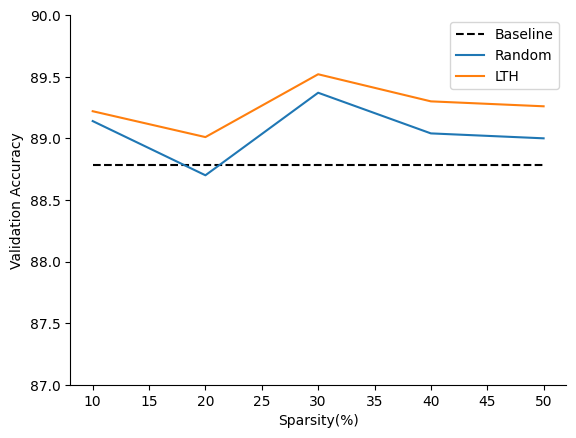

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=[10, 20, 30, 40, 50], y=[88.78, 88.78, 88.78, 88.78, 88.78], linestyle="--", label="Baseline", color="black")
sns.lineplot(x=[10, 20, 30, 40, 50], y=[89.14, 88.70, 89.37, 89.04, 89.00], label="Random")
sns.lineplot(x=[10, 20, 30, 40, 50], y=[89.22, 89.01, 89.52, 89.30, 89.26], label="LTH")
plt.ylim(87, 90)
plt.xlabel("Sparsity(%)")
plt.ylabel("Validation Accuracy")
sns.despine()